In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50

# 데이터셋 로드
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='C:/Users/2060/Downloads/flower',
    download=False,
    with_info=True,
    as_supervised=True,
)

# 데이터 전처리 함수 정의
BATCH_SIZE = 32
IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # ResNet 전용 전처리
    return image, label

#전처리 적용
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

#셔플 및 배치 생성 
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

def create_model():
    # 기본 모델 변경
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # 사전 학습된 레이어 고정 (학습되지 않도록 설정)
    for layer in base_model.layers:
        layer.trainable = False
    
    # 새 분류기 레이어 구성
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(5, activation='softmax')
    ])
    return model

model = create_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
from tensorflow.keras.optimizers import RMSprop, Adam

configs = [
    {"learning_rate": 0.001, "optimizer": RMSprop, "epochs": 5},
    {"learning_rate": 0.0001, "optimizer": RMSprop, "epochs": 10},
    {"learning_rate": 0.001, "optimizer": Adam, "epochs": 5},
    {"learning_rate": 0.0001, "optimizer": Adam, "epochs": 10}
]


In [11]:
# 결과 저장 리스트 초기화
results = []

# 모델 학습 및 결과 기록
for i, config in enumerate(configs):
    print(f"\n--- Running Configuration {i+1} ---")
    
    # 새로운 모델 생성
    model = create_model()
    
    # 옵티마이저 초기화
    optimizer = config["optimizer"](learning_rate=config["learning_rate"])
    
    # 모델 컴파일
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 모델 학습
    history = model.fit(
        train_batches,
        epochs=config["epochs"],
        validation_data=validation_batches,
        verbose=2
    )
    
    # 테스트 성능 평가
    test_loss, test_accuracy = model.evaluate(test_batches, verbose=0)
    
    # 결과 저장 (학습 이력 및 테스트 성능)
    results.append({
        "config": config,
        "history": history.history,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    })



--- Running Configuration 1 ---
Epoch 1/5
92/92 - 118s - 1s/step - accuracy: 0.8140 - loss: 0.6763 - val_accuracy: 0.9101 - val_loss: 0.2938
Epoch 2/5
92/92 - 109s - 1s/step - accuracy: 0.9087 - loss: 0.2481 - val_accuracy: 0.8774 - val_loss: 0.4432
Epoch 3/5
92/92 - 111s - 1s/step - accuracy: 0.9523 - loss: 0.1361 - val_accuracy: 0.8447 - val_loss: 0.5885
Epoch 4/5
92/92 - 114s - 1s/step - accuracy: 0.9673 - loss: 0.0925 - val_accuracy: 0.8856 - val_loss: 0.4248
Epoch 5/5
92/92 - 120s - 1s/step - accuracy: 0.9847 - loss: 0.0474 - val_accuracy: 0.8556 - val_loss: 0.4920

--- Running Configuration 2 ---
Epoch 1/10
92/92 - 119s - 1s/step - accuracy: 0.7953 - loss: 0.5797 - val_accuracy: 0.8856 - val_loss: 0.3183
Epoch 2/10
92/92 - 121s - 1s/step - accuracy: 0.9193 - loss: 0.2471 - val_accuracy: 0.8965 - val_loss: 0.2673
Epoch 3/10
92/92 - 120s - 1s/step - accuracy: 0.9489 - loss: 0.1648 - val_accuracy: 0.9019 - val_loss: 0.2690
Epoch 4/10
92/92 - 111s - 1s/step - accuracy: 0.9680 - loss

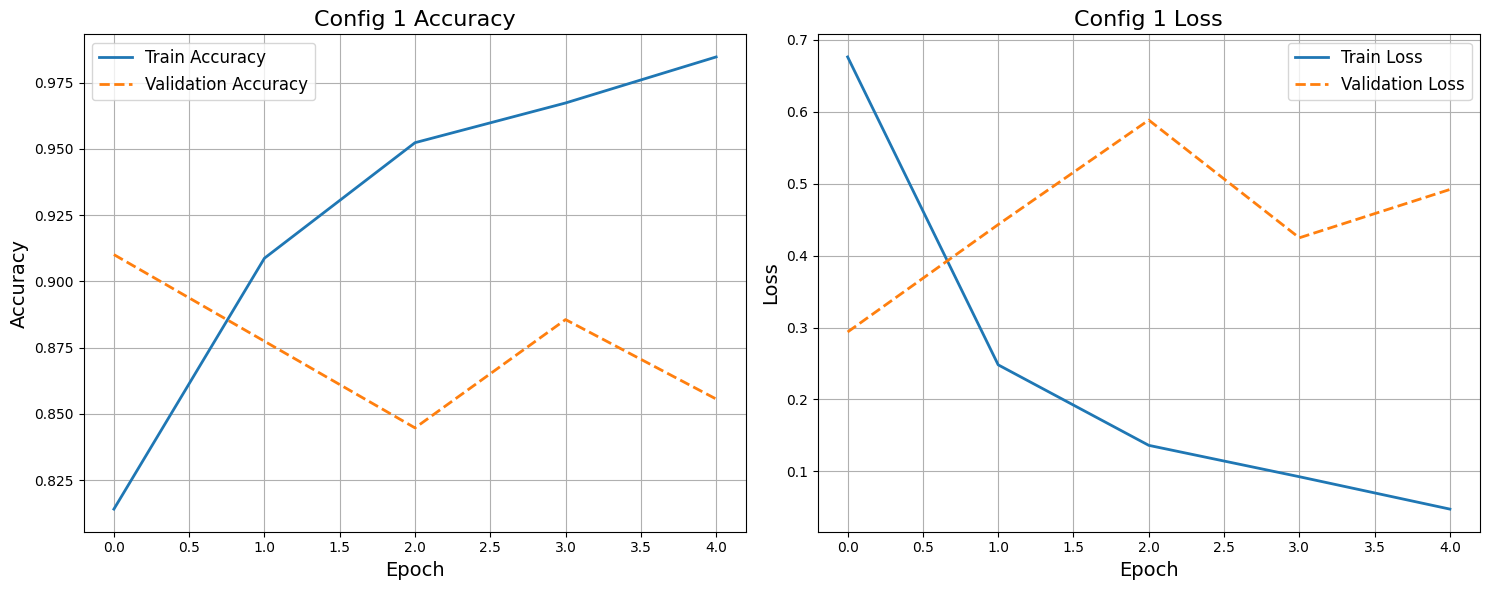

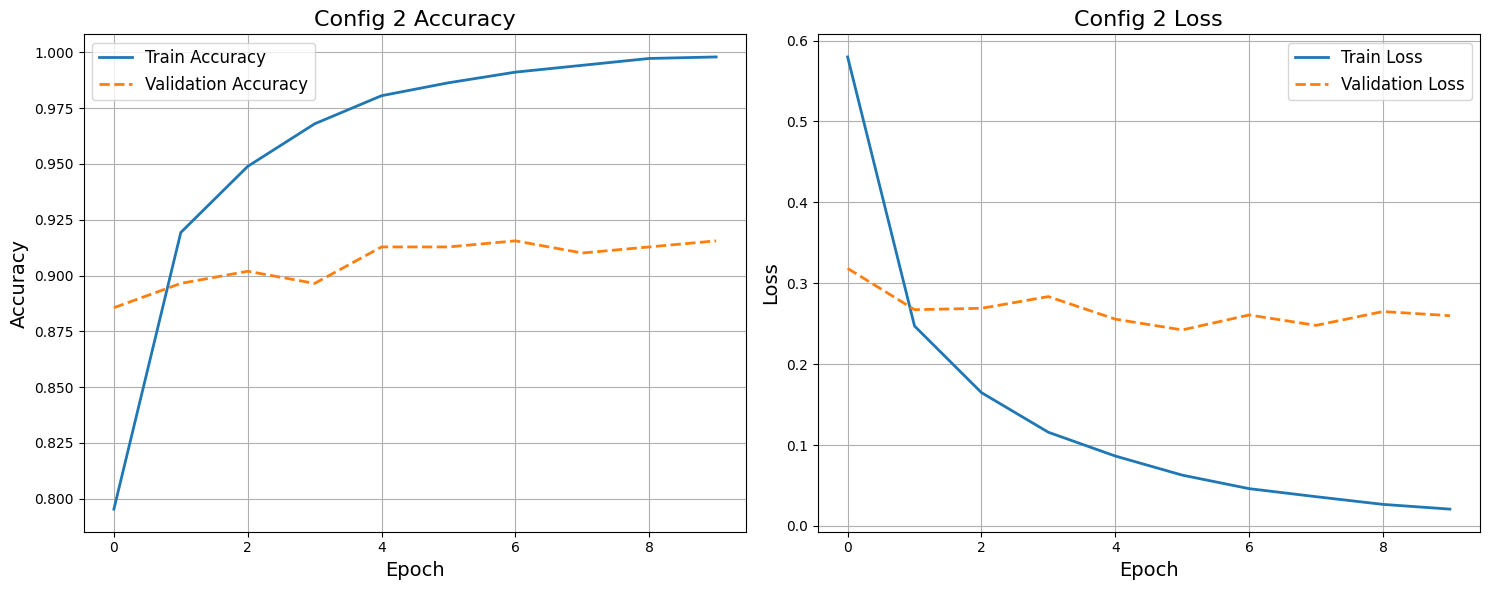

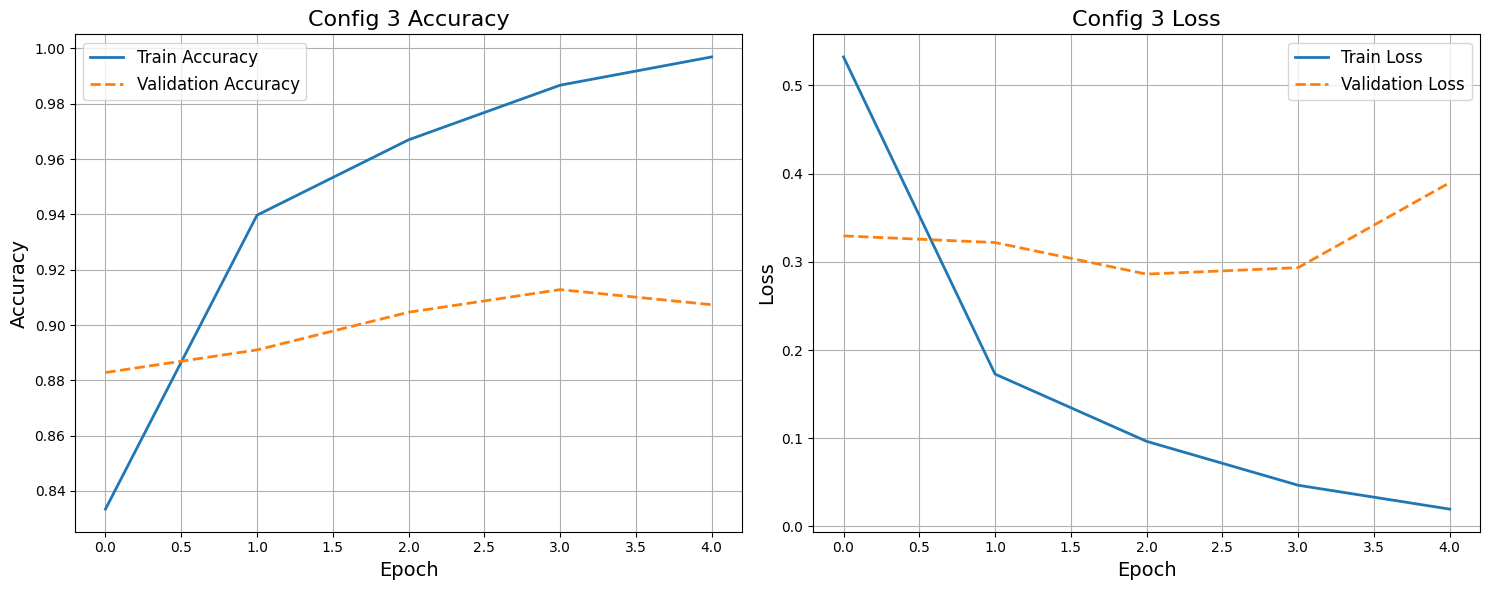

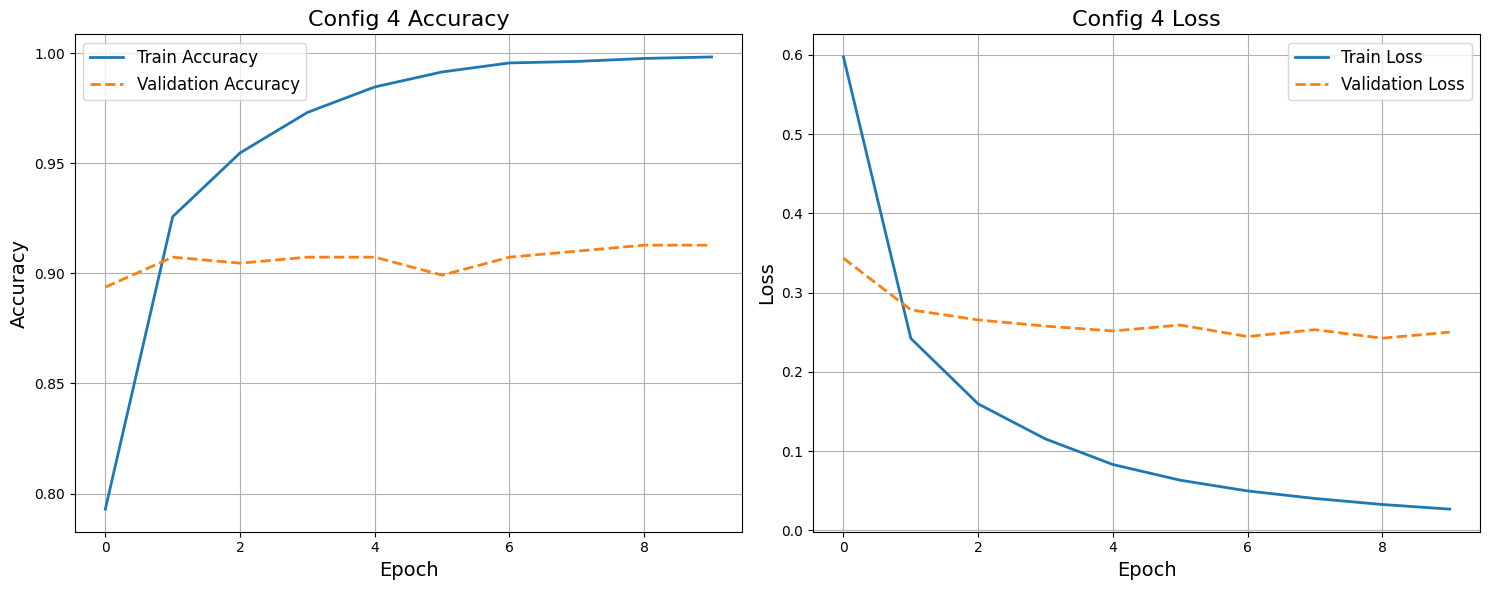

In [12]:
import matplotlib.pyplot as plt

for i, result in enumerate(results):
    plt.figure(figsize=(15, 6))
    
    
    plt.subplot(1, 2, 1) 
    plt.plot(result['history']['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy', linestyle='--', linewidth=2)
    plt.title(f'Config {i+1} Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True) 
    
    
    plt.subplot(1, 2, 2)  
    plt.plot(result['history']['loss'], label='Train Loss', linewidth=2)
    plt.plot(result['history']['val_loss'], label='Validation Loss', linestyle='--', linewidth=2)
    plt.title(f'Config {i+1} Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)  
    
    plt.tight_layout()
    plt.show()


In [13]:
# 테스트 성능 출력
for i, result in enumerate(results):
    print(f"\nConfiguration {i+1}:")
    print(f"Learning Rate: {result['config']['learning_rate']}")
    print(f"Optimizer: {result['config']['optimizer'].__name__}")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")



Configuration 1:
Learning Rate: 0.001
Optimizer: RMSprop
Test Loss: 0.4687
Test Accuracy: 0.8883

Configuration 2:
Learning Rate: 0.0001
Optimizer: RMSprop
Test Loss: 0.2064
Test Accuracy: 0.9319

Configuration 3:
Learning Rate: 0.001
Optimizer: Adam
Test Loss: 0.3316
Test Accuracy: 0.8965

Configuration 4:
Learning Rate: 0.0001
Optimizer: Adam
Test Loss: 0.1936
Test Accuracy: 0.9401


- Configuration 결과 요약

    - Configuration 1: Learning Rate: 0.001, Optimizer: RMSprop, Test Accuracy: 88.83%
    - Configuration 2: Learning Rate: 0.0001, Optimizer: RMSprop, Test Accuracy: 93.19%
    - Configuration 3: Learning Rate: 0.001, Optimizer: Adam, Test Accuracy: 89.65%
    - Configuration 4: Learning Rate: 0.0001, Optimizer: Adam, Test Accuracy: 94.01%

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


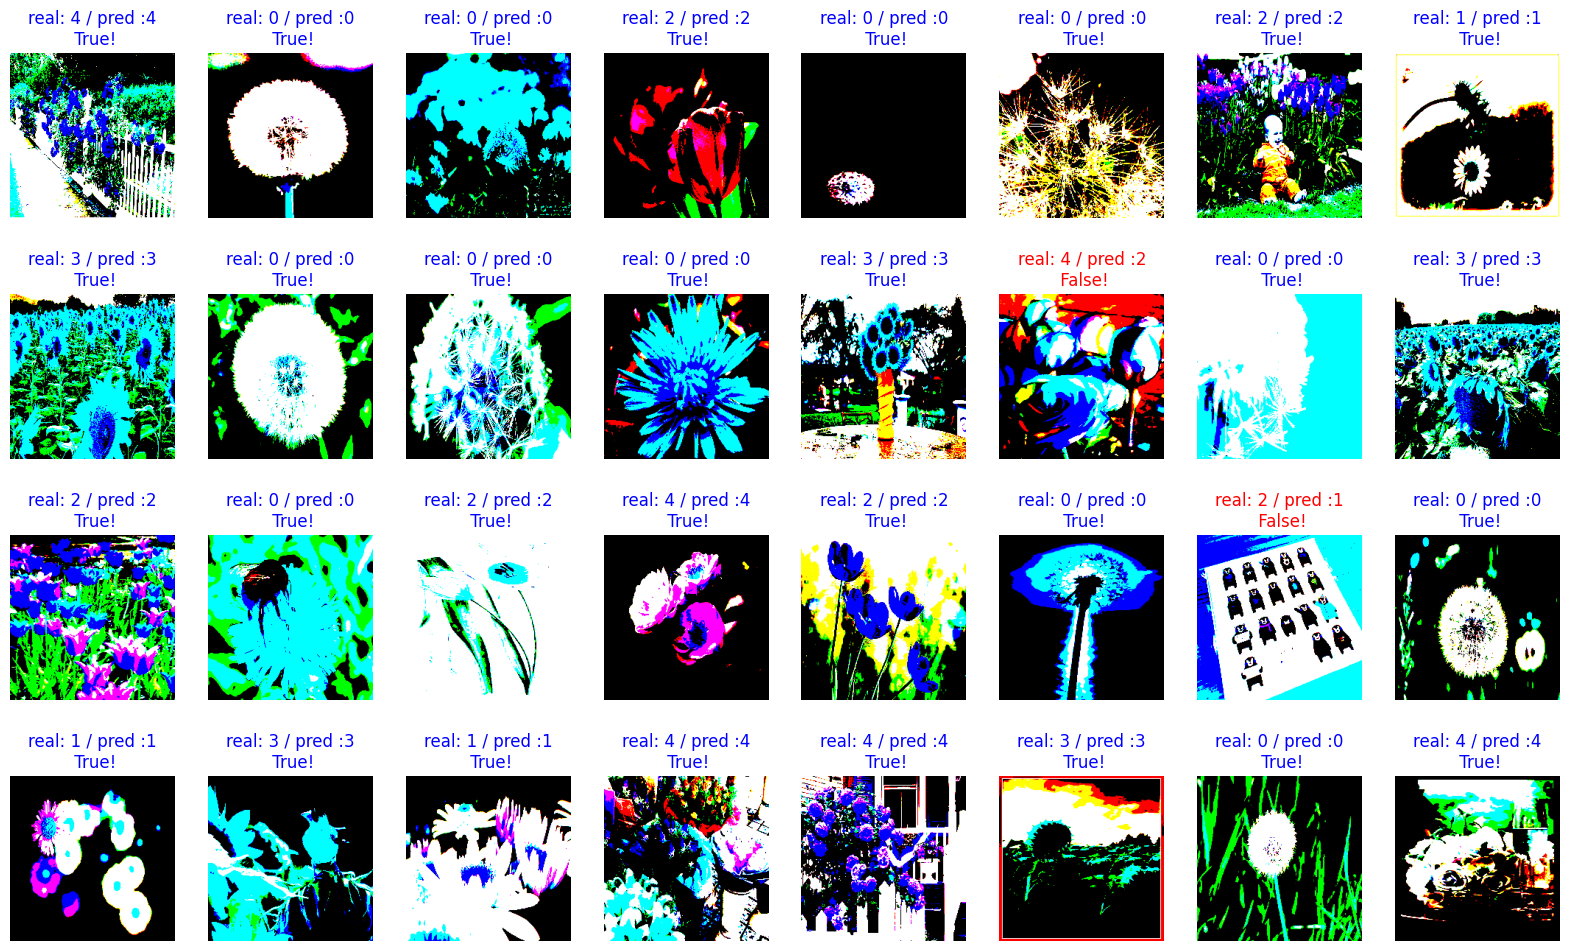

In [ ]:
import numpy as np

for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions = np.argmax(predictions, axis=1)

for image_batch, label_batch in test_batches.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')